In [ ]:
import pandas as pd
import numpy as np
from zipfile import ZipFile 
import cv2
import os
import keras
from os import getcwd
from os import listdir
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation, ReLU, Flatten

In [ ]:
zipFile = 'mask detection.zip'
with ZipFile(zipFile, 'r') as zip:
  zip.extractall()

In [ ]:
size = 128
def load_images_from_folder(folder):
    images = []
    for filename in sorted(os.listdir(folder)):
      img = cv2.imread(os.path.join(folder,filename))
      img = cv2.resize(img, (size, size), interpolation=cv2.INTER_AREA)
      if img is not None:
        images.append(img)
    return images

In [ ]:
mask_images = load_images_from_folder('observations-master/experiements/data/with_mask')
unmasked_images = load_images_from_folder('observations-master/experiements/data/without_mask')

In [ ]:
mask_labels = [1] * len(mask_images)
unmasked_labels = [0] * len(unmasked_images)

In [ ]:
data = mask_images + unmasked_images

In [ ]:
labels = mask_labels + unmasked_labels

In [ ]:
len(labels)

1376

In [ ]:
len(data)

1376

In [ ]:
data = np.asarray(data)
labels = np.asarray(labels)
# unmasked_images = np.asarray(unmasked_images)

In [ ]:
data = data.astype('float32')
# unmasked_images = unmasked_images.astype('float32')

In [ ]:
data = data/np.max(data[0])
# unmasked_images = unmasked_images/np.max(unmasked_images[0])

In [ ]:
# data = np.concatenate((mask_images, unmasked_images), axis = 0)
# labels = np.concatenate((mask_labels, unmasked_labels), axis = 0)

In [ ]:
data, labels = shuffle(data, labels)

1


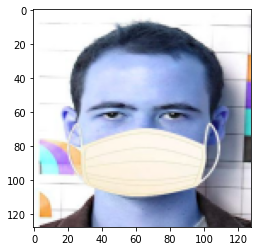

In [ ]:
n = 1326
print(labels[n])
plt.imshow(data[n])
plt.show()


In [ ]:
data.shape

(1376, 128, 128, 3)

In [ ]:
# "datagen" will be used later for generating data in learning phase
datagen = ImageDataGenerator(
        featurewise_center=False,             # set input mean to 0 over the dataset
        samplewise_center=False,              # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,   # divide each input by its std
        zca_whitening=False,                  # apply ZCA whitening
        rotation_range=0,        # randomly rotate images in the range (degrees, 0 to 180)
        # zoom_range = [0.95, 1.05],
        width_shift_range=0.1,   # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,    # randomly flip images
vertical_flip=False)             # randomly flip images


In [ ]:
# datagen = ImageDataGenerator(rescale=1.0/255,
#                                    rotation_range=40,
#                                    width_shift_range=0.2,
#                                    height_shift_range=0.2,
#                                    shear_range=0.2,
#                                    zoom_range=0.2,
#                                    horizontal_flip=True,
#                                    fill_mode='nearest')

In [ ]:

model = Sequential()
model.add(Conv2D(100, (3, 3), activation='elu', padding='same', input_shape=data.shape[1:]))
model.add(BatchNormalization())
# model.add(Conv2D(64, (3, 3), activation='elu', padding='same'))
# model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.5))

model.add(Conv2D(128, (3, 3), activation='elu', padding='same'))
model.add(BatchNormalization())
# model.add(Conv2D(128, (3, 3), activation='elu', padding='same'))
# model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

# model.add(Conv2D(256, (3, 3), activation='elu', padding='same'))
# model.add(BatchNormalization())
# model.add(Conv2D(256, (3, 3), activation='elu', padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.6))

# model.add(Conv2D(256, (3, 3), activation='elu', padding='same'))
# model.add(BatchNormalization())
# model.add(Conv2D(256, (3, 3), activation='elu', padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.5))
#kernel_initializer='he_uniform'
# example output part of the model
model.add(Flatten())
model.add(Dense(128, activation='elu'))
model.add(Dropout(0.5))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))
# model.add(Dense(128, activation='elu'))
# model.add(Dropout(0.5))
# model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

In [ ]:
opt = keras.optimizers.SGD(learning_rate=0.005)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=200)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [ ]:
datagen.fit(data)
model.fit_generator(datagen.flow(data[:1200], labels[:1200], batch_size=128), epochs = 10,
                    callbacks = [es, mc],
                    validation_data = (data[1200:], labels[1200:])
                    )
#model.fit(train_images_arr, train_labels_encoded, steps_per_epoch=100, epochs=20)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.0729 - accuracy: 0.9742
Epoch 00001: val_accuracy did not improve from 0.98295
10/10 [==============================] - 4s 397ms/step - loss: 0.0729 - accuracy: 0.9742 - val_loss: 0.0720 - val_accuracy: 0.9830
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.0533 - accuracy: 0.9775
Epoch 00002: val_accuracy did not improve from 0.98295
10/10 [==============================] - 4s 434ms/step - loss: 0.0533 - accuracy: 0.9775 - val_loss: 0.0778 - val_accuracy: 0.9659
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.0556 - accuracy: 0.9775
Epoch 00003: val_accuracy did not improve from 0.98295
10/10 [==============================] - 4s 396ms/step - loss: 0.0556 - accuracy: 0.9775 - val_loss: 0.0858 - val_accuracy: 0.9716
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.0710 - accuracy: 0.9675
Epoch 00004: val_accuracy did not improve from 0.98295
10/10 [====

In [ ]:
from tensorflow import keras
model1 = keras.models.load_model('best_model.h5')